# 8.2 Combining and Merging Datasets（合并数据集）


> 8.1中的操作名
- join：连接
- combine：合并
- reshape：整形

> 8.2中的操作名
> - merge：归并
- concatenate：串联

> 8.3中的操作名
- pivot：旋转
- stack：堆叠

> 我在整个第八章对这些翻译做了更新，其他章节可能没有统一，如果有发现到不统一的翻译，可以在issue里提出，也可以直接pull request


pandas里有几种方法可以合并数据：

1. pandas.merge 按一个或多个key把DataFrame中的行连接起来。这个和SQL或其他一些关系型数据库中的join操作相似。
2. pandas.concat 在一个axis（轴）上，串联或堆叠（stack）多个对象。
3. combine_first 实例方法（instance method）能合并相互之间有重复的数据，并用一个对象里的值填满缺失值

这里每一个都会给出一些例子。这些用法贯穿这本书。

# 1 Database-Style DataFrame Joins（数据库风格的DataFrame Joins）

Merge或join操作，能通过一个或多个key，把不同的数据集的行连接在一起。这种操作主要集中于关系型数据库。pandas中的merge函数是这种操作的主要切入点：

In [1]:
import pandas as pd
import numpy as np

In [6]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [7]:
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})
df2

,key,data2
0,a,0
1,b,1
2,d,2


这个例子是many-to-one join（多个变为一个的连接）；在df1中有标签为a和b的行，而df2中的key列，每一行只有对应的一个值。调用merge我们可以得到：

In [8]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


这里我们并没有指定按哪一列来连接。如果我们没有指定，merge会用两个对象中都存在的列名作为key（键）。当然，最好还是清楚指定比较好：

In [9]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


如果每一个对象中的列名不一会，我们可以分别指定：

In [13]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'], 
                             'data1': range(7)})

df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'], 
                             'data2': range(3)})
df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [12]:
df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [14]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


我们可能注意到，在结果中并没有c和d。因为merge默认是inner join(内连接)，结果中的key是交集的结果，或者在两个表格中都有的集合。其他一些可选项，比如left, right, outer。outer join（外连接）取key的合集，其实就是left join和right join同时应用的效果：

In [15]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


这里是how的一些选项：

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/ysx07.png)

many-to-many(多对多)连接也被定义好了，不过可能不是那么直观。这里有一个例子：

In [16]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'], 
                    'data1': range(6)})

df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [17]:
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'], 
                    'data2': range(5)})
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [18]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


many-to-many join是对行进行笛卡尔积运算。（两个集合X和Y的笛卡儿积（Cartesian product），又称直积，在集合论中表示为X × Y，是所有可能的有序对组成的集合。比如1到13是一个集合，四种花色是一个集合，二者的笛卡尔积就有52个元素）。这里在左侧的DataFrame中有三行含b，右边的DataFrame则有两行含b，于是结果是有六行含b。这个join方法只会让不相同的key值出现在最后的结果里：

In [19]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


用多个key来连接的话，用一个含有多个列名的list来指定：

In [20]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'], 
                     'key2': ['one', 'two', 'one'], 
                     'lval': [1, 2, 3]})

right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'], 
                      'key2': ['one', 'one', 'one', 'two'], 
                      'rval': [4, 5, 6, 7]})

In [21]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


哪一种key组合会出现在结果里取决于merge方法的选择，可以把多个key当做一个tuple组成的单一key（尽管实际上并不是这样）。

注意：当我们讲列和列进行连接时，DataFrame中的index对象会被丢弃。


最后一个问题是在做merge操作的时候，如何处理重叠的列名。当我们想要手动去解决重叠问题时（参考重命名axis labels的部分），merge有一个suffixes选项，能让我们指定字符串，添加重叠的列名到左、右DataFrame：

In [22]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [23]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


下表是mege的一些参数。用DataFrame的row index来联结会在下一部分讲到。

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/7ec11.png)

# 2 Merging on Index（在index上做归并）

在一些情况下，用于归并的key（键），可能是DataFrame中的index。这种情况下，可以使用left_index=True 或 right_index=True来指明，哪一个index被用来作为归并键：

In [24]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'], 
                      'value': range(6)})

left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [25]:
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])
right1

,group_val
a,3.5
b,7.0


In [26]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


merge的默认方法是用key的交集，我们也可以设定用合集，即outer join:

In [27]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


对于那些有多层级索引的数据，就更复杂了。index上的merge默认会是multiple-key merge(复数键归并)：

In [28]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio',
                               'Nevada', 'Nevada'], 
                      'key2': [2000, 2001, 2002, 2001, 2002], 
                      'data': np.arange(5.)})
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [29]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 
                              'Ohio', 'Ohio'], 
                             [2001, 2000, 2000, 2000, 2001, 2002]], 
                      columns=['event1', 'event2'])
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

在这个例子里，我们必须指明将多列归并作为一个list（注意处理重复index的方法是令how='outer'）:

In [30]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], 
         right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [31]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
         right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


同时使用两个对象里的index来归并也是可能的：

In [32]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]], 
                     index=['a', 'c', 'e'], 
                     columns=['Ohio', 'Nevada'])

left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [33]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]], 
                      index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [34]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame有一个很便利的join实例，可以直接用index来连接。这个也可以用于与其他DataFrame进行连接，要有一样的index但不能有重叠的列：

In [35]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


由于一些历史原因，在早期的pandas版本中，DataFrame的join方法是在连接键上做left join（左连接），这样会保留左侧Dataframe的行索引。这也支持把传入的dataframe的index与被调用的DataFrame的column连接在一起：

In [36]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


最后，对于简单的index-on-index连接，可以直接给join传入一个DataFrame。（作为备选，也可以使用最普遍的concat函数，这个在下一节会做介绍）：

In [37]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]], 
                       index=['a', 'c', 'e', 'f'], 
                       columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [38]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [39]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0
b,NaN,NaN,7.0,8.0,NaN,NaN
d,NaN,NaN,11.0,12.0,NaN,NaN
f,NaN,NaN,NaN,NaN,16.0,17.0


# 2 Concatenating Along an Axis（沿着轴串联）

另一种结合方式被称为可互换的，比如concatenation, binding, or stacking(串联，绑定，堆叠)。Numpy中的concatenate函数可以作用于numpy 数组：

In [40]:
arr = np.arange(12.).reshape((3, 4))
arr

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [41]:
np.concatenate([arr, arr], axis=1)

array([[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.,  8.,  9., 10., 11.]])

而在pandas的对象中，比如Series和DataFrame，labeled axes（便签化的轴）能让我们做更泛化的数组串联操作。不过我们可能会有下面一些疑问：

- 如果一个对象在其他轴上的index不同，我们应不应该在这些轴上把不同的元素合并起来，或者只用交集?

- 经过串联操作后，连接的部分在输出对象里应不应该是可被识别的？

- concatenation axis（串联轴）含有的数据需要被保留吗？在很多情况下，DataFrame中一些用整数做的label（标签）其实最好在串联后被删除。

pandas中的concat函数能解决上面这些问题。这里会给出几个例子来说明。假设我们有三个Series，他们指明没有index overlap(索引重叠)：

In [42]:
s1 = pd.Series([0, 1], index=['a', 'b'])

s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])

s3 = pd.Series([5, 6], index=['f', 'g'])

调用concat，把上面的series放在一个list里，结果会把值和索引都整合在一起：

In [43]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

默认情况下，concat中axis=0,结果会得到一个新的而series。如果令axis=1, 结果会变成一个DataFrame（axis=1 是列）：

In [44]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


这种情况下，不会与其他轴产生重叠，效果与join中的outer join一样。你也可以通过设定join='inner'来使用交集：

In [45]:
s4 = pd.concat([s1, s3])
s4

a    0
b    1
f    5
g    6
dtype: int64

In [46]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [49]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


因为join='inner'，所以f和g标签消失了。

你也可以在join_axes中指定使用哪些轴：

In [54]:
# pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

#join_axes 已经 deprecated 了，使用 reindex
#e.g. pandas.concat([df1,..,dfn],axis=1).reindex(df1.columns)
#https://stackoverflow.com/questions/27391081/concatenating-pandas-and-join-axes

一个潜在的问题是串联的部分在结果里是不可辨识的。假设我们想在串联轴上创建一个多层级索引，我们需要用到keys参数：

In [55]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [56]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


如果是设定axis=1，那么keys会变为DataFrame的column header(列头):

In [57]:
print(s1)
print(s2)
print(s3)

a    0
b    1
dtype: int64
c    2
d    3
e    4
dtype: int64
f    5
g    6
dtype: int64


In [58]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


这种逻辑也可以扩展到DataFrame对象上：

In [59]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'], 
                   columns=['one', 'two'])

df1

,one,two
a,0,1
b,2,3
c,4,5


In [60]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'], 
                   columns=['three', 'four'])
df2

,three,four
a,5,6
c,7,8


In [61]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

如果导入一个dict而不是list，那么dict的key会被用于上面concat中的keys选项：

In [62]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

还有其他一些选项负责多层级索引的设定（表8-3）。比如，可以给创建的axis level(轴层级)用names参数来命名：

In [63]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
          names=['upper', 'lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

最后我们关心的是，在DataFrame中，行索引（row index）没有包含相关的数据：

In [64]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df1

,a,b,c,d
0,-0.581835,0.640862,1.248058,-0.161989
1,-0.395067,-1.445162,1.089622,2.093056
2,-1.162017,0.895546,-1.046069,0.555604


In [65]:
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df2

,b,d,a
0,0.285170,-1.016027,1.256165
1,0.722915,-0.274747,-0.223671


这种情况下，可以设置ignore_index=True:

In [66]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-0.581835,0.640862,1.248058,-0.161989
1,-0.395067,-1.445162,1.089622,2.093056
2,-1.162017,0.895546,-1.046069,0.555604
3,1.256165,0.285170,NaN,-1.016027
4,-0.223671,0.722915,NaN,-0.274747


concat函数的一些参数：

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/hnq2u.png)

![](http://oydgk2hgw.bkt.clouddn.com/pydata-book/1w4z1.png)

# 3 Combining Data with Overlap（用重叠来合并数据）

另一种数据合并方法既不属于merge，也不属于concatenation。比如两个数据集，index可能完全覆盖，或覆盖一部分。这里举个例子，考虑下numpy的where函数，可以在数组上进行类似于if-else表达式般的判断：

In [73]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan], 
              index=['f', 'e', 'd', 'c', 'b', 'a'])

a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [77]:
b = pd.Series(np.arange(len(a), dtype=np.float64), 
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    5.0
dtype: float64

In [78]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, 5. ])

Series有一个combine_first方法，效果和上面是一样，而且还会自动对齐（比如把index按字母进行排列）：

In [79]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

对于DataFrame， combine_first可以在列与列之间做到同样的事情，可以认为是用传递的对象，给调用对象中的缺失值打补丁：

In [80]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan], 
                    'b': [np.nan, 2., np.nan, 6.], 
                    'c': range(2, 18, 4)})

df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [81]:
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.], 
                    'b': [np.nan, 3., 4., 6., 8.]})
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [82]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


join 和 append 是 concat 的简版：
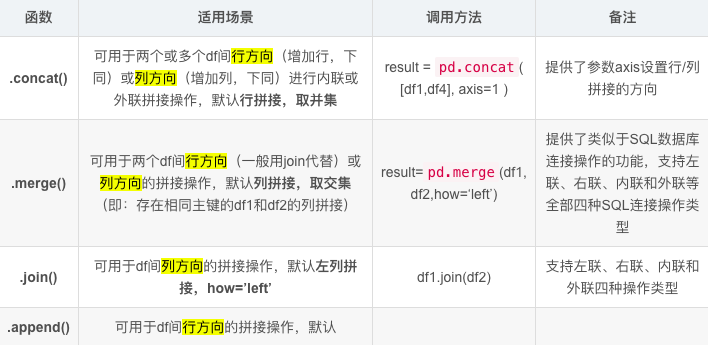

merge 是合并2个库， concat 是把第二个库扩展到第一个库：
- https://stackoverflow.com/questions/38256104/differences-between-merge-and-concat-in-pandas
- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html